<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/Deep_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
av_vols = np.mean(train_vols[3], axis = 0)

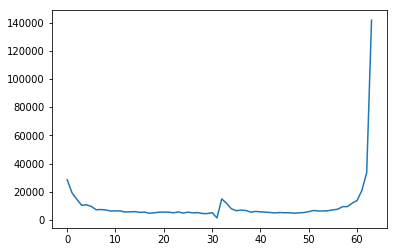

In [11]:
plt.plot(av_vols)

In [0]:
#create covariates - currently one hot vector 64 dims but experiment with different ideas 
def create_covariate_data(input_data, freq = 64): #this is assuming that data starts at beginning of day and ends at last bin of the day 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  covariate_vectors = np.zeros((num_series, len_series, freq+1))
  
  for n in range(num_series):
    for d in range(days): 
      for t in range(freq): 
        one_hot = np.zeros(freq)
        one_hot[t] = 1
        covariate_vectors[n, d*freq + t, 0] = input_data[n, d*freq + t]
        covariate_vectors[n, d*freq + t, 1:] = one_hot
        
  return covariate_vectors

In [0]:
#alternative covariate function 
#inputs - input_data of shape [number of time series, length of each time series], freq of data i.e. number of bins per day, and position of special bins as a vector
#returns - data and covariate vector of shape [number of series, length of series, number of special bins + 2] where covariate_vectors[:,:,0] is the input data, 
#covariate_vectors[:,:,1] is the scaled time of day and covariate_vectors[:,:,2:] is the one hot vector for the special bins
#therefore covariate_vectors[:,:,0] is the data and covariate_vectors[:,:,1:] is the actual covariate vector 

def new_create_covariate_data(input_data, freq, pos_of_special_bins): 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  num_special_bins = len(pos_of_special_bins)
  covariate_vectors = np.zeros((num_series, len_series, num_special_bins+2))
  
  for n in range(num_series): 
    for d in range(days): 
      for t in range(freq): 
        x = np.zeros(num_special_bins + 1)
        #x[0] is the scaled time of day 
        x[0] = t/freq
        
        check = t in pos_of_special_bins
        
        if check == True: 
          index = pos_of_special_bins.index(t)
          x[index+1] = 1
          
        covariate_vectors[n, d*freq + t, 0] = input_data[n, d*freq + t]
        covariate_vectors[n, d*freq + t, 1:] = x
        
  return covariate_vectors
        

In [0]:
train_volume = train_vols[0:50].reshape((50,-1))

norm_train_vols = np.zeros(train_volume.shape)
for i in range(50): 
  norm_train_vols[i] = train_volume[i]/np.amax(train_vols[i])
  
T = 64*3
new_train_data = norm_train_vols[:,:T]

covars_data = new_create_covariate_data(new_train_data, 64, [0,31,32,63])

covars_data = torch.FloatTensor(covars_data)

In [0]:
test_volume = train_vols[50:100].reshape((50,-1))

norm_test_vols = np.zeros(test_volume.shape)
for i in range(50): 
  norm_test_vols[i] = test_volume[i]/np.amax(train_vols[i])
  
T = 64*3
new_test_data = norm_test_vols[:,:T]

covars_test_data = new_create_covariate_data(new_test_data, 64, [0,31,32,63])

covars_test_data = torch.FloatTensor(covars_test_data)

In [0]:
#class for the global model 
#forward pass - input data of shape []
#forward pass outputs fixed effects of shape []

class GlobalEffects(nn.Module): 
  def __init__(self, input_size, num_factors, hidden_size, batch_size, output_size = 1, num_layers = 1): 
    super().__init__()
    self.input_size = input_size
    self.num_factors = num_factors
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.linears = nn.ModuleList([nn.Linear(self.hidden_size, self.output_size, bias = False) for i in range(self.num_factors)])
    self.lstms = nn.ModuleList([nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers) for i in range(self.num_factors)])
    
    self.w = torch.nn.Parameter(torch.zeros(batch_size, num_factors))
    
  def init_hidden(self): 
    hidden = [torch.zeros(self.num_layers, self.batch_size, self.hidden_size) for i in range(self.num_factors)]
    return hidden
    
  def forward(self, input_data, hidden): 
    x = input_data[:,:,1:]
    for i in range(self.num_factors): 
      lstm_out, hidden[i] = self.lstms[i](x.view(x.shape[1], self.batch_size, -1))
      g_i = self.linears[i](lstm_out).view(1, self.batch_size, -1) #shape of g_i = [1, batch_size, seq_len]
      
      if i == 0: 
        g = g_i
      else:
        g = torch.cat((g,g_i), dim=0)

    fixed_effects = torch.zeros((self.batch_size, g.shape[2]))
    
    for i in range(self.batch_size): 
      for j in range(g.shape[2]): 
        fixed_effects[i,j] = torch.dot(self.w[i], g[:,i,j])
      
    return fixed_effects
     
      

In [0]:
#class for the DF-RNN local model 
#forward pass inputs: fixed effects output from global model, input data of shape [] and whether or not to assume a gaussian likelihood 
#forward pass outputs log likelihood for the given data

class DF_RNN(nn.Module): 
  def __init__(self, input_size, hidden_size, batch_size, num_series, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_series = num_series
    
    self.rnns = nn.ModuleList([nn.RNN(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = 1) for i in range(self.num_series)])
    self.linears = nn.ModuleList([nn.Linear(self.hidden_size, self.output_size) for i in range(self.num_series)])
    
  def init_hidden(self): 
    hidden = [torch.zeros(1, self.batch_size, self.hidden_size) for i in range(self.num_series)]
    return hidden
    
  def forward(self, input_data, hidden, fixed_effects, gaussian_likelihood): 
    z = input_data[:,:,0]
    x = input_data[:,:,1:]
    
    sigma = torch.zeros((self.num_series, x.shape[1]))
    r = torch.zeros(sigma.shape)
    
    #log_lik = torch.zeros(self.num_series)
    
    for i in range(self.num_series): 
      data = x[i]
      rnn_out, hidden[i] = self.rnns[i](data.view(data.shape[0], self.batch_size, -1))
      sig = self.linears[i](rnn_out).view(-1)
      
      sigma[i] = torch.abs(sig)
      
      for j in range(sigma.shape[1]):
        r[i,j] = torch.distributions.normal.Normal(0, sigma[i,j]).rsample()
    
    if gaussian_likelihood == True: 
      log_lik = self.log_likelihood_Gaussian(z, fixed_effects, sigma)

    else: 
      pass

      #log_lik[i] = log_likelihood
      
    u = fixed_effects + r
    
    return log_lik, sigma
   
  def log_likelihood_Gaussian(self, z, f, sigma):
    log_p = torch.zeros(sigma.shape)
    
    for i in range(sigma.shape[0]):
      for j in range(sigma.shape[1]): 
        log_pdf = torch.distributions.normal.Normal(0, sigma[i,j]).log_prob(z[i,j] - f[i,j])
        #scale the likelihood to 0-1
        log_norm_constant = torch.distributions.normal.Normal(0, sigma[i,j]).log_prob(0)
        log_p[i,j] = log_pdf - log_norm_constant
    
    log_lik = torch.sum(log_p)

    return log_lik
  
  
  
  def log_likelihood_nonGaussian(self, ): #to do 
    pass

In [0]:
learning_rate = 0.001
batch_size = 50 #??????
num_epochs = 200
hidden_units_global = 50
hidden_units_local = 5
n_factors = 10 

In [208]:
torch.autograd.set_detect_anomaly(False)

In [0]:
global_model = GlobalEffects(input_size = 5, num_factors = n_factors , hidden_size = hidden_units_global, batch_size= 50)  
local_model = DF_RNN(5, hidden_size = hidden_units_local, batch_size = 1, num_series = 50, output_size = 1)

In [0]:
## TRAINING ##

optimiser = torch.optim.SGD(list(global_model.parameters()) + list(local_model.parameters()), lr = learning_rate)

train_loss = []
test_loss = []
 
for t in range(num_epochs): 
  global_model.zero_grad()
  global_hidden = global_model.init_hidden()
  
  local_model.zero_grad()
  local_hidden = local_model.init_hidden()
  
  data_batch = covars_data
  
  fixed_effects = global_model(data_batch, global_hidden)

  log_lik, sigma = local_model(data_batch, local_hidden, fixed_effects, gaussian_likelihood = True)

  batch_loss = -1*log_lik
    
  optimiser.zero_grad()
  
  batch_loss.backward()

  optimiser.step()
  
  train_loss.append(batch_loss.item())
  
  with torch.no_grad():
    test_data_batch = covars_test_data
    fixed_effects = global_model(test_data_batch, global_hidden)
    
    data = test_data_batch
    log_lik, sigma = local_model(data, local_hidden, fixed_effects, gaussian_likelihood = True)
      
    test_batch_loss = -1*log_lik
      
    test_loss.append(test_batch_loss.item())
  
  print("Epoch: ", t, "loss: ", batch_loss.item(), "test loss: ", test_batch_loss.item())

Epoch:  0 loss:  368373.9375 test loss:  6421.89501953125
Epoch:  1 loss:  511.3743591308594 test loss:  771.5874633789062
Epoch:  2 loss:  16.113447189331055 test loss:  750.0118408203125
Epoch:  3 loss:  14.33482551574707 test loss:  737.8549194335938
Epoch:  4 loss:  13.268628120422363 test loss:  734.8265991210938
Epoch:  5 loss:  12.432352066040039 test loss:  741.7972412109375
Epoch:  6 loss:  11.741040229797363 test loss:  761.1307983398438
Epoch:  7 loss:  11.155841827392578 test loss:  797.894287109375
Epoch:  8 loss:  10.652003288269043 test loss:  862.6184692382812
Epoch:  9 loss:  10.212528228759766 test loss:  978.7911376953125
Epoch:  10 loss:  9.825209617614746 test loss:  1206.7852783203125
Epoch:  11 loss:  9.481022834777832 test loss:  1744.0838623046875
Epoch:  12 loss:  9.173032760620117 test loss:  3587.584716796875
Epoch:  13 loss:  8.895734786987305 test loss:  21177.689453125
Epoch:  14 loss:  8.644830703735352 test loss:  94487.4296875
Epoch:  15 loss:  8.43523

In [0]:
plt.plot(train_loss[1:])

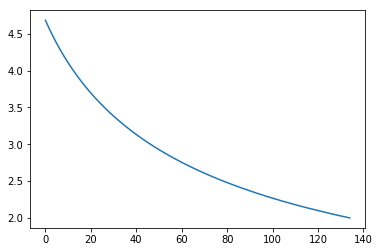

In [40]:
plt.plot(test_loss)

In [0]:
num_paths = 100 
pred_length = 64 
T = ??

In [0]:
## PREDICTION ## for one example
paths = np.zeros((num_paths, T + pred_length))

with torch.no_grad(): 
  
  test_data = ...
  
  for n in range(num_paths): 
    
    fixed_effects = global_model(test_data, global_hidden)
    log_lik, sigma = local_model(data, local_hidden, fixed_effects, gaussian_likelihood = True)
    
    z = torch.zeros(sigma.shape[0])
    for t in range(sigma.shape[0]):
      z[t] = torch.distributions.normal.Normal(0, sigma[t]).rsample() #OR z = torch.distributions.normal.Normal(fixed_effects[t], sigma[t]).rsample() 
      
    paths[n,:T] = input_test_data[:,0]
    paths[n, T:] = z